# Risk Deep Dive: Geographic & Temporal Analysis
   
   Detailed risk analysis for AXA Deutschland bike-share insurance pricing.
   
   **Prerequisites**: Run `make scorecard MODE=nyc` first.
   
   **Audience**: Technical teams, actuaries, data scientists

## How to run (recommended)

From the repo root:

```bash
make all MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
make report MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
```

The Makefile sets environment variables (e.g. `CITIBIKE_PARQUET_DIR`, `CITIBIKE_YEARS`, `CITIBIKE_MONTHS`) which this notebook reads.


## Analysis Overview
   
   This notebook provides detailed risk analysis including:
   1. **High-Risk Station Identification** - Top 10% riskiest stations
   2. **Geographic Clustering** - Do high-risk stations cluster?
   3. **Risk Distribution** - How is risk distributed across the system?
   4. **Temporal Patterns** - When is exposure highest?
   5. **Executive Summary** - AXA-ready metrics
   
   **Run time**: ~2 minutes

In [1]:
# --- Setup (STRICT): load summaries + FORCE year/month risk tables (NO overall fallback) ---

from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Notebook-friendly display
try:
    from IPython.display import display, Markdown
except Exception:
    display = print
    Markdown = lambda x: x

# Ensure figures render in executed notebook
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

plt.ioff()  # nbconvert-friendly

# ---------------------------
# Repo discovery
# ---------------------------
def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "Makefile").exists():
            return p
    raise FileNotFoundError(f"Could not find repo root (Makefile) from CWD={Path.cwd().resolve()}")

REPO_ROOT = find_repo_root(Path.cwd())
SUMMARIES_ROOT = REPO_ROOT / "summaries"

# ---------------------------
# Helpers
# ---------------------------
def _parse_int_list(val: str | None):
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    parts = re.split(r"[,\s]+", s)
    out = []
    for p in parts:
        if not p:
            continue
        try:
            out.append(int(p))
        except Exception:
            pass
    return out or None

def read_csv_strict(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing required CSV: {path}")
    return pd.read_csv(path)

def read_csv_optional(path: Path) -> pd.DataFrame | None:
    return pd.read_csv(path) if path.exists() else None

def _filter_year_month(df: pd.DataFrame, years: list[int] | None, months: list[int] | None) -> pd.DataFrame:
    out = df.copy()
    if years is not None and "year" in out.columns:
        out["year"] = pd.to_numeric(out["year"], errors="coerce")
        out = out[out["year"].isin(years)]
    if months is not None and "month" in out.columns:
        out["month"] = pd.to_numeric(out["month"], errors="coerce")
        out = out[out["month"].isin(months)]
    return out

# ---------------------------
# Inputs from Makefile
# ---------------------------
PARQUET_DIR_ENV = (os.environ.get("CITIBIKE_PARQUET_DIR") or "").strip()
RUN_DIR_ENV     = (os.environ.get("CITIBIKE_RUN_DIR") or "").strip()
MODE_ENV        = (os.environ.get("CITIBIKE_MODE") or os.environ.get("MODE") or "").strip().lower()

YEARS_FILTER  = _parse_int_list(os.environ.get("CITIBIKE_YEARS")  or os.environ.get("YEARS"))
MONTHS_FILTER = _parse_int_list(os.environ.get("CITIBIKE_MONTHS") or os.environ.get("MONTHS"))

PARQUET_DIR = Path(PARQUET_DIR_ENV) if PARQUET_DIR_ENV else Path()

if RUN_DIR_ENV:
    RUN_DIR = Path(RUN_DIR_ENV)
else:
    run_tag = PARQUET_DIR.name if str(PARQUET_DIR).strip() else ""
    RUN_DIR = (SUMMARIES_ROOT / run_tag) if run_tag else Path()

# Resolve relative -> absolute
if str(RUN_DIR).strip() and not RUN_DIR.is_absolute():
    RUN_DIR = (REPO_ROOT / RUN_DIR).resolve()
if str(PARQUET_DIR).strip() and not PARQUET_DIR.is_absolute():
    PARQUET_DIR = (REPO_ROOT / PARQUET_DIR).resolve()

# ---------------------------
# Strict checks
# ---------------------------
if not SUMMARIES_ROOT.exists():
    raise FileNotFoundError(f"Expected summaries/ folder at: {SUMMARIES_ROOT}")
if not RUN_DIR.exists():
    raise FileNotFoundError(f"Expected run summaries at: {RUN_DIR}")

print("REPO_ROOT:", REPO_ROOT)
print("RUN_DIR:", RUN_DIR)
print("PARQUET_DIR:", PARQUET_DIR if str(PARQUET_DIR).strip() else "(not set)")
print("MODE (env):", MODE_ENV or "(not set)")
print("YEARS_FILTER:", YEARS_FILTER, "MONTHS_FILTER:", MONTHS_FILTER)

# Figures dir
FIG_DIR = REPO_ROOT / "reports" / RUN_DIR.name / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR)

def savefig(filename: str):
    out = FIG_DIR / filename
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

# ---------------------------
# Load core per-run summaries (required)
# ---------------------------
df_year  = read_csv_strict(RUN_DIR / "citibike_trips_by_year.csv")
df_month = read_csv_strict(RUN_DIR / "citibike_trips_by_month.csv")
df_dow   = read_csv_strict(RUN_DIR / "citibike_trips_by_dow.csv")
df_hour  = read_csv_strict(RUN_DIR / "citibike_trips_by_hour.csv")

# Optional outputs
df_station = read_csv_optional(RUN_DIR / "citibike_station_exposure.csv")

# ---------------------------
# Load RISK (FORCE granular)
# ---------------------------
risk_year_path = RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year.csv"
risk_ym_path   = RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year_month.csv"

df_risk_year = read_csv_optional(risk_year_path)
df_risk_ym   = read_csv_optional(risk_ym_path)

# Force granular selection (no overall fallback)
if df_risk_ym is not None:
    df_risk = df_risk_ym
    risk_source = "by_year_month"
elif df_risk_year is not None:
    df_risk = df_risk_year
    risk_source = "by_year"
else:
    df_risk = None
    risk_source = "missing"
    raise FileNotFoundError(
        "No per-year/per-month risk CSVs found in RUN_DIR.\n"
        f"Expected one of:\n  - {risk_ym_path}\n  - {risk_year_path}\n"
        "If you truly want overall-only risk, load station_risk_exposure_plus_crashproximity.csv explicitly (but you said you don't)."
    )

# Highlights
highlights_path = RUN_DIR / "summary_highlights.md"

# Mode detection
mode = (
    str(df_year["mode"].iloc[0]).lower()
    if ("mode" in df_year.columns and len(df_year))
    else (MODE_ENV or "unknown")
)
print("Detected mode:", mode)

# Apply filters defensively
df_year  = _filter_year_month(df_year,  YEARS_FILTER, MONTHS_FILTER)
df_month = _filter_year_month(df_month, YEARS_FILTER, MONTHS_FILTER)
df_dow   = _filter_year_month(df_dow,   YEARS_FILTER, MONTHS_FILTER)
df_hour  = _filter_year_month(df_hour,  YEARS_FILTER, MONTHS_FILTER)

df_risk  = _filter_year_month(df_risk,  YEARS_FILTER, MONTHS_FILTER)

run_label = RUN_DIR.name

print("\nRisk files found:")
print(" - by_year:", "YES" if df_risk_year is not None else "NO")
print(" - by_year_month:", "YES" if df_risk_ym is not None else "NO")
print("Using df_risk =", risk_source)
print("df_risk columns:", list(df_risk.columns))
print("Unique years in df_risk:", sorted(pd.to_numeric(df_risk["year"], errors="coerce").dropna().unique().astype(int).tolist()) if "year" in df_risk.columns else "(no year)")
print("Unique months in df_risk:", sorted(pd.to_numeric(df_risk["month"], errors="coerce").dropna().unique().astype(int).tolist()) if "month" in df_risk.columns else "(no month)")


REPO_ROOT: /home/maral/Desktop/citibike-insurance-challenge
RUN_DIR: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2017_2023_m1_2_3_modenyc
PARQUET_DIR: /home/maral/Desktop/citibike-insurance-challenge/data/processed/citibike_parquet/y2017_2023_m1_2_3_modenyc
MODE (env): nyc
YEARS_FILTER: [2017, 2023] MONTHS_FILTER: [1, 2, 3]
FIG_DIR: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_3_modenyc/figures
Detected mode: nyc

Risk files found:
 - by_year: YES
 - by_year_month: YES
Using df_risk = by_year_month
df_risk columns: ['mode', 'start_station_id', 'start_station_name', 'year', 'month', 'trips', 'start_trips', 'end_trips', 'touchpoints', 'station_lat', 'station_lng', 'crashes_within_500m', 'crashes_within_500m_per_100k_trips', 'risk_proxy_available', 'data_quality']
Unique years in df_risk: [2017, 2023]
Unique months in df_risk: [1, 2, 3]


## 8) Risk Deep Dive Analysis

Now that we have the AXA scorecard, let's analyze:
- **WHERE**: Which stations are highest risk? Do they cluster geographically?
- **WHEN**: Does risk vary by hour of day or day of week?
- **WHO**: What exposure levels do high-risk stations have?

This analysis helps AXA:
1. **Price accurately**: Understand risk distribution
2. **Target prevention**: Find geographic clusters for safety campaigns
3. **Optimize products**: Match offerings to temporal patterns

In [2]:
# ============================================================================
# LOAD SCORECARD (overall) + SHOW RISK separated by YEAR and YEAR-MONTH
# ============================================================================

import os
import re
from pathlib import Path
import pandas as pd

print("\n" + "="*70)
print("RISK DEEP DIVE (Scorecard overall + Risk separated by time)")
print("="*70)

# ---------------------------
# Scorecard loading (overall, by design)
# ---------------------------
_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        raise ValueError(f"Bad AXA_RADIUS={raw!r}. Use like 450m, 750, 1km, auto.")
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    if meters <= 0:
        raise ValueError(f"AXA_RADIUS must be > 0 (got {raw!r})")
    return int(round(meters))

def available_scorecards(run_dir: Path) -> list[int]:
    radii = []
    for p in run_dir.glob("axa_partner_scorecard_*m.csv"):
        mm = re.match(r"^axa_partner_scorecard_(\d+)m\.csv$", p.name)
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def pick_scorecard_path(run_dir: Path, radius_env: str) -> Path | None:
    avail = available_scorecards(run_dir)
    if not avail:
        return None
    wanted = parse_radius_to_m(radius_env)
    chosen = max(avail) if wanted == -1 else (wanted if wanted in avail else (500 if 500 in avail else max(avail)))
    p = run_dir / f"axa_partner_scorecard_{chosen}m.csv"
    return p if p.exists() else None

radius_env = os.environ.get("AXA_RADIUS", "auto")
scorecard_path = pick_scorecard_path(RUN_DIR, radius_env)

if scorecard_path and scorecard_path.exists():
    df_score = pd.read_csv(scorecard_path)
    print(f"✅ Loaded scorecard (overall): {len(df_score):,} stations")
    print(f"   AXA_RADIUS (env): {radius_env} -> using file: {scorecard_path.name}")
    display(df_score.head(5))
else:
    df_score = None
    print("❌ Scorecard not found. Available:", available_scorecards(RUN_DIR))

# ---------------------------
# Risk sanity (guaranteed granular by setup cell)
# ---------------------------
if df_risk is None:
    raise RuntimeError("df_risk is None (setup should have forced granular risk).")

if "year" not in df_risk.columns:
    raise RuntimeError(f"df_risk unexpectedly has no 'year' column. Columns: {list(df_risk.columns)}")

r = df_risk.copy()
r["year"] = pd.to_numeric(r["year"], errors="coerce")
if "month" in r.columns:
    r["month"] = pd.to_numeric(r["month"], errors="coerce")

# Find crash radius columns (crashes_within_<R>m)
crash_cols = [c for c in r.columns if re.match(r"^crashes_within_\d+m$", str(c))]
if not crash_cols:
    raise RuntimeError(f"No crashes_within_<R>m columns in df_risk. Columns: {list(r.columns)}")

# Pick one radius for “summary” tables (prefer 500m)
crash_col = "crashes_within_500m" if "crashes_within_500m" in crash_cols else crash_cols[0]
print("\nUsing crash_col for summaries:", crash_col)

# Clean trips
r["trips"] = pd.to_numeric(r.get("trips", pd.NA), errors="coerce")
r = r.dropna(subset=["year", "trips"]).copy()
r = r[r["trips"] > 0].copy()

# ---------------------------
# YEARLY summary (separated)
# ---------------------------
yearly = (
    r.groupby(["year"], as_index=False)
     .agg(trips=("trips", "sum"), crashes=(crash_col, "sum"))
     .sort_values("year")
)
yearly["crashes_per_100k_trips"] = yearly["crashes"] / yearly["trips"] * 100000.0

print("\n=== Yearly crash-proximity summary ===")
display(yearly)

# ---------------------------
# YEAR-MONTH summary (separated, if month exists)
# ---------------------------
if "month" in r.columns:
    ym = (
        r.dropna(subset=["month"])
         .groupby(["year","month"], as_index=False)
         .agg(trips=("trips","sum"), crashes=(crash_col,"sum"))
         .sort_values(["year","month"])
    )
    ym["crashes_per_100k_trips"] = ym["crashes"] / ym["trips"] * 100000.0

    print("\n=== Year-Month crash-proximity summary (first rows) ===")
    display(ym.head(24))

    # show each year separately (so it never “looks overall”)
    for yy in sorted(ym["year"].dropna().unique().astype(int).tolist()):
        print(f"\n--- Year {yy} month breakdown ---")
        display(ym[ym["year"] == yy].copy())
else:
    print("\n(df_risk has no 'month' column; only yearly separation is possible.)")



RISK DEEP DIVE (Scorecard overall + Risk separated by time)
✅ Loaded scorecard (overall): 2,535 stations
   AXA_RADIUS (env): 500m -> using file: axa_partner_scorecard_500m.csv


,mode,start_station_id,start_station_name,station_lat,station_lng,exposure_trips,crash_count,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,...,risk_pct,axa_priority_score,prevention_hotspot,product_hotspot,acquisition_hotspot,exposure_index_pct,eb_risk_rate_per_100k_trips,risk_index_pct,expected_incidents_proxy,scoring_strategy
0,nyc,6602.03,W 41 St & 8 Ave,40.756405,-73.990026,35258,500,1418.117874,1296.524411,1548.043759,...,0.353288,1.000000,False,True,False,99.605523,1453.950685,35.328754,512.633933,eb_expected_incidents_mintrips5000_mprior1000
1,nyc,523,W 38 St & 8 Ave,40.754666,-73.991382,24804,506,2039.993549,1866.095631,2225.734672,...,0.605496,0.999606,False,True,False,97.948718,2066.243371,60.549558,512.511006,eb_expected_incidents_mintrips5000_mprior1000
2,nyc,5414.06,Allen St & Rivington St,40.720196,-73.989978,19773,510,2579.274769,2360.250909,2813.154337,...,0.748773,0.999211,False,True,False,94.280079,2585.921337,74.877331,511.314226,eb_expected_incidents_mintrips5000_mprior1000
3,nyc,477,W 41 St & 8 Ave,40.756405,-73.990026,27002,500,1851.714688,1692.943400,2021.366079,...,0.544652,0.998817,False,True,False,98.500986,1882.627810,54.465162,508.347161,eb_expected_incidents_mintrips5000_mprior1000
4,nyc,6602.05,W 42 St & 8 Ave,40.757570,-73.990985,19089,500,2619.309550,2394.722494,2859.286859,...,0.757605,0.998422,False,True,False,93.491124,2624.189554,75.760550,500.931544,eb_expected_incidents_mintrips5000_mprior1000



Using crash_col for summaries: crashes_within_500m

=== Yearly crash-proximity summary ===


,year,trips,crashes,crashes_per_100k_trips
0,2017,4491962,87709,1952.576625
1,2023,11205462,85365,761.815979



=== Year-Month crash-proximity summary (first rows) ===


,year,month,trips,crashes,crashes_per_100k_trips
0,2017,1,1453351,28892,1987.957486
1,2017,2,1583288,25948,1638.867976
2,2017,3,1455323,32869,2258.536421
3,2023,1,3585737,27762,774.234139
4,2023,2,3387525,26191,773.160346
5,2023,3,4232200,31412,742.214451



--- Year 2017 month breakdown ---


,year,month,trips,crashes,crashes_per_100k_trips
0,2017,1,1453351,28892,1987.957486
1,2017,2,1583288,25948,1638.867976
2,2017,3,1455323,32869,2258.536421



--- Year 2023 month breakdown ---


,year,month,trips,crashes,crashes_per_100k_trips
3,2023,1,3585737,27762,774.234139
4,2023,2,3387525,26191,773.160346
5,2023,3,4232200,31412,742.214451


### 8.1 High-Risk Stations: WHO and WHERE


HIGH-RISK STATIONS ANALYSIS

High-risk stations (≥90th percentile): 102
Total exposure at high-risk stations: 789,412 trips

📍 Top 10 Highest-Risk Stations:


,start_station_id,start_station_name,station_lat,station_lng,exposure_trips,crash_count,eb_risk_rate_per_100k_trips,risk_index_pct
43,3134,3 Ave & E 62 St,40.763126,-73.965269,5621,468,7478.831588,100.000000
37,5414.07,Delancey St & Eldridge St,40.719383,-73.991479,5848,478,7376.948590,99.901865
73,6441.06,W 37 St & Broadway,40.752271,-73.987706,5150,425,7352.413649,99.803729
50,6723.10,E 58 St & 1 Ave (NW Corner),40.759125,-73.962658,5663,450,7161.540438,99.705594
46,6723.1,E 58 St & 1 Ave (NW Corner),40.759125,-73.962658,6726,450,6176.202943,99.607458
172,6682.08,E 60 St & York Ave,40.759107,-73.959223,5282,354,6067.708364,99.509323
141,5430.10,6 Ave & Walker St,40.719792,-74.005224,5581,369,6019.958052,99.411187
10,473,Rivington St & Chrystie St,40.721101,-73.991925,8203,506,5793.474295,99.313052
106,6441.02,Broadway & W 37 St,40.751726,-73.987535,6388,383,5551.887377,99.214917
87,6313.1,Lexington Ave & E 36 St,40.747574,-73.978801,6925,395,5327.109646,99.116781


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_3_modenyc/figures/top10_highest_risk_stations.png


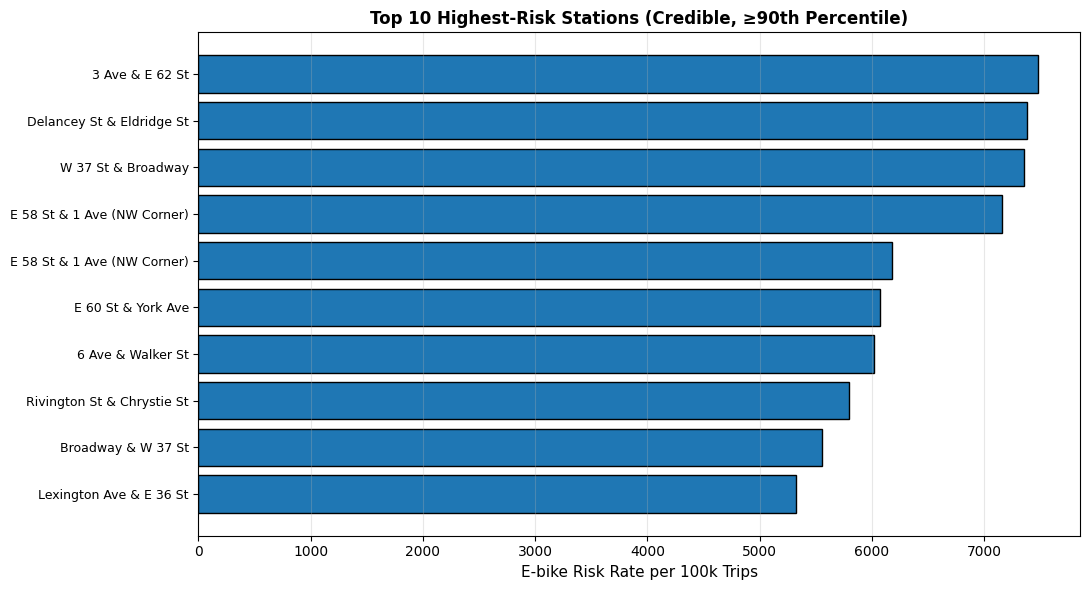

✓ Saved plot: top10_highest_risk_stations.png



🗺️  Geographic Clustering:
  High-risk clusters identified: 4
  Isolated high-risk stations: 5

Cluster Details:


,stations_in_cluster,exposure_trips,crash_count,station_lat,station_lng
cluster,,,,,
0.0,35,291590,12366,40.718729,-73.998831
1.0,43,358509,16051,40.757380,-73.975818
2.0,17,102281,4419,40.690499,-73.984430
3.0,2,10451,414,40.716062,-73.944683


In [3]:
# --- HIGH-RISK STATIONS (robust + consistent columns) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if df_score is None or len(df_score) == 0:
    print("⚠️  df_score is None/empty (no scoring data available)")
else:
    print("\n" + "="*70)
    print("HIGH-RISK STATIONS ANALYSIS")
    print("="*70)

    s = df_score.copy()

    # ---- Resolve column names robustly ----
    id_col   = "start_station_id"   if "start_station_id"   in s.columns else ("station_id"   if "station_id"   in s.columns else None)
    name_col = "start_station_name" if "start_station_name" in s.columns else ("station_name" if "station_name" in s.columns else None)
    lat_col  = "station_lat" if "station_lat" in s.columns else ("lat" if "lat" in s.columns else None)
    lng_col  = "station_lng" if "station_lng" in s.columns else ("lng" if "lng" in s.columns else None)

    # Required metrics
    risk_pct_col = "risk_index_pct" if "risk_index_pct" in s.columns else None
    rate_col     = "eb_risk_rate_per_100k_trips" if "eb_risk_rate_per_100k_trips" in s.columns else None
    exposure_col = "exposure_trips" if "exposure_trips" in s.columns else ("trips" if "trips" in s.columns else None)
    crash_col    = "crash_count" if "crash_count" in s.columns else None
    cred_col     = "credibility_flag" if "credibility_flag" in s.columns else None

    missing_required = [k for k, v in {
        "station_id": id_col,
        "station_name": name_col,
        "risk_index_pct": risk_pct_col,
        "eb_risk_rate_per_100k_trips": rate_col,
        "exposure_trips": exposure_col,
    }.items() if v is None]

    if missing_required:
        print("⚠️  Cannot run high-risk analysis; missing columns:", missing_required)
        print("Available columns:", list(s.columns))
    else:
        # ---- Clean numeric columns ----
        s[risk_pct_col] = pd.to_numeric(s[risk_pct_col], errors="coerce")
        s[rate_col]     = pd.to_numeric(s[rate_col], errors="coerce")
        s[exposure_col] = pd.to_numeric(s[exposure_col], errors="coerce")

        if crash_col is not None:
            s[crash_col] = pd.to_numeric(s[crash_col], errors="coerce")

        # ---- Credible filter (if available) ----
        if cred_col is not None:
            credible_stations = s[s[cred_col].astype(str).str.lower() == "credible"].copy()
        else:
            credible_stations = s.copy()
            print("⚠️  No credibility_flag column; using all stations as 'credible_stations'.")

        credible_stations = credible_stations.dropna(subset=[risk_pct_col, rate_col, exposure_col])

        if len(credible_stations) == 0:
            print("⚠️  No credible stations with usable risk data.")
        else:
            # High-risk = >= 90th percentile
            high_risk = credible_stations[credible_stations[risk_pct_col] >= 90].copy()

            print(f"\nHigh-risk stations (≥90th percentile): {len(high_risk):,}")
            print(f"Total exposure at high-risk stations: {high_risk[exposure_col].sum():,.0f} trips")

            # Top 10 by risk rate
            cols_to_show = [id_col, name_col]
            if lat_col: cols_to_show.append(lat_col)
            if lng_col: cols_to_show.append(lng_col)
            cols_to_show += [exposure_col]
            if crash_col: cols_to_show.append(crash_col)
            cols_to_show += [rate_col, risk_pct_col]

            top_risk = (
                high_risk.sort_values(rate_col, ascending=False)
                        .head(10)[cols_to_show]
                        .copy()
            )

            print("\n📍 Top 10 Highest-Risk Stations:")
            display(top_risk)

            # ---- Plot: Top 10 Highest-Risk Stations ----
            try:
                top_plot = top_risk.sort_values(rate_col, ascending=True).copy()
                fig, ax = plt.subplots(figsize=(11, 6))

                y = np.arange(len(top_plot))
                ax.barh(y, top_plot[rate_col].values, edgecolor="black")

                ax.set_yticks(y)
                ax.set_yticklabels([str(n)[:40] for n in top_plot[name_col]], fontsize=9)
                ax.set_xlabel("E-bike Risk Rate per 100k Trips", fontsize=11)
                ax.set_title("Top 10 Highest-Risk Stations (Credible, ≥90th Percentile)", fontsize=12, fontweight="bold")
                ax.grid(axis="x", alpha=0.3)

                plt.tight_layout()
                savefig("top10_highest_risk_stations.png")
                plt.show()
                print("✓ Saved plot: top10_highest_risk_stations.png")
            except Exception as e:
                print(f"⚠️  Could not generate top10 plot: {e}")

            # ---- Geographic clustering (optional) ----
            if lat_col and lng_col and len(high_risk) > 1:
                try:
                    from sklearn.cluster import DBSCAN

                    coords = high_risk[[lat_col, lng_col]].dropna().values
                    if len(coords) < 2:
                        print("⚠️  Not enough lat/lng data for clustering.")
                    else:
                        clustering = DBSCAN(eps=0.01, min_samples=2).fit(coords)
                        # align back to high_risk rows that had coords
                        idx_valid = high_risk[[lat_col, lng_col]].dropna().index
                        high_risk.loc[idx_valid, "cluster"] = clustering.labels_

                        labels = clustering.labels_.tolist()
                        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                        n_noise = labels.count(-1)

                        print(f"\n🗺️  Geographic Clustering:")
                        print(f"  High-risk clusters identified: {n_clusters}")
                        print(f"  Isolated high-risk stations: {n_noise}")

                        if n_clusters > 0:
                            # cluster summary
                            agg_map = {
                                id_col: "count",
                                exposure_col: "sum",
                            }
                            if crash_col:
                                agg_map[crash_col] = "sum"
                            agg_map[lat_col] = "mean"
                            agg_map[lng_col] = "mean"

                            cluster_summary = (
                                high_risk[high_risk["cluster"] >= 0]
                                .groupby("cluster")
                                .agg(agg_map)
                                .rename(columns={id_col: "stations_in_cluster"})
                            )

                            print("\nCluster Details:")
                            display(cluster_summary)
                except ImportError:
                    print("⚠️  sklearn not installed - skipping geographic clustering")
                    print("   Install with: pip install scikit-learn")


### 8.2 Risk Distribution Overview


RISK DISTRIBUTION ANALYSIS


/tmp/ipykernel_22277/2898809091.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_3_modenyc/figures/08_risk_distribution_analysis.png


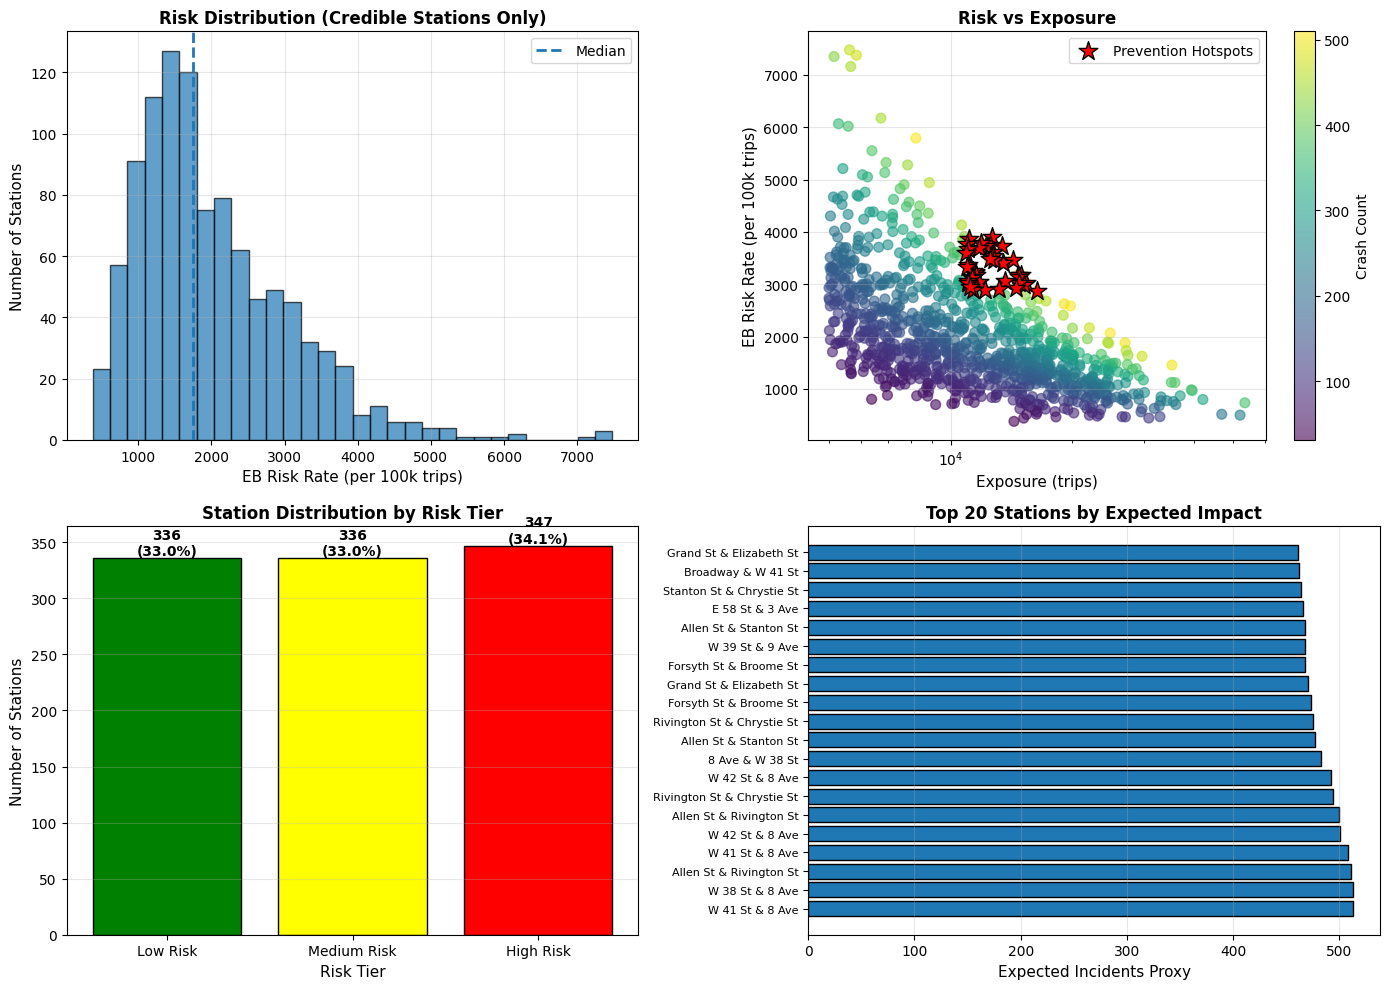

In [4]:
# --- RISK DISTRIBUTION (robust + tier colors Low=green, Medium=yellow, High=red) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if df_score is None or len(df_score) == 0:
    print("⚠️  df_score is None/empty (no scoring data available)")
else:
    print("\n" + "="*70)
    print("RISK DISTRIBUTION ANALYSIS")
    print("="*70)

    s = df_score.copy()

    # Resolve key columns
    cred_col     = "credibility_flag" if "credibility_flag" in s.columns else None
    risk_pct_col = "risk_index_pct" if "risk_index_pct" in s.columns else None
    rate_col     = "eb_risk_rate_per_100k_trips" if "eb_risk_rate_per_100k_trips" in s.columns else None
    exposure_col = "exposure_trips" if "exposure_trips" in s.columns else ("trips" if "trips" in s.columns else None)
    crash_col    = "crash_count" if "crash_count" in s.columns else None
    exp_inc_col  = "expected_incidents_proxy" if "expected_incidents_proxy" in s.columns else None

    # station name (for plot 4)
    name_col = "start_station_name" if "start_station_name" in s.columns else ("station_name" if "station_name" in s.columns else None)

    # Basic requirements for most plots
    if rate_col is None or exposure_col is None:
        print("⚠️  Missing required columns for distribution plots.")
        print("Need at least:", ["eb_risk_rate_per_100k_trips", "exposure_trips/trips"])
        print("Available columns:", list(s.columns))
    else:
        # Clean numeric
        s[rate_col] = pd.to_numeric(s[rate_col], errors="coerce")
        s[exposure_col] = pd.to_numeric(s[exposure_col], errors="coerce")
        if crash_col is not None:
            s[crash_col] = pd.to_numeric(s[crash_col], errors="coerce")
        if risk_pct_col is not None:
            s[risk_pct_col] = pd.to_numeric(s[risk_pct_col], errors="coerce")
        if exp_inc_col is not None:
            s[exp_inc_col] = pd.to_numeric(s[exp_inc_col], errors="coerce")

        # Credible filter
        if cred_col is not None:
            credible_stations = s[s[cred_col].astype(str).str.lower() == "credible"].copy()
        else:
            credible_stations = s.copy()
            print("⚠️  No credibility_flag column; using all stations as 'credible_stations'.")

        credible_stations = credible_stations.dropna(subset=[rate_col, exposure_col])

        if len(credible_stations) == 0:
            print("⚠️  No credible stations with usable risk+exposure data.")
        else:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            # 1) Risk Histogram
            ax = axes[0, 0]
            vals = credible_stations[rate_col].dropna()
            ax.hist(vals, bins=30, edgecolor="black", alpha=0.7)
            ax.axvline(vals.median(), linestyle="--", linewidth=2, label="Median")
            ax.set_xlabel("EB Risk Rate (per 100k trips)", fontsize=11)
            ax.set_ylabel("Number of Stations", fontsize=11)
            ax.set_title("Risk Distribution (Credible Stations Only)", fontsize=12, fontweight="bold")
            ax.legend()
            ax.grid(alpha=0.3)

            # 2) Exposure vs Risk Scatter (color by crash_count if available)
            ax = axes[0, 1]
            if crash_col is not None:
                scatter = ax.scatter(
                    credible_stations[exposure_col],
                    credible_stations[rate_col],
                    c=credible_stations[crash_col].fillna(0),
                    alpha=0.6,
                    s=50
                )
                plt.colorbar(scatter, ax=ax, label="Crash Count")
            else:
                ax.scatter(
                    credible_stations[exposure_col],
                    credible_stations[rate_col],
                    alpha=0.6,
                    s=50
                )
            ax.set_xlabel("Exposure (trips)", fontsize=11)
            ax.set_ylabel("EB Risk Rate (per 100k trips)", fontsize=11)
            ax.set_title("Risk vs Exposure", fontsize=12, fontweight="bold")
            ax.set_xscale("log")
            ax.grid(alpha=0.3)

            # Mark prevention hotspots if present
            if "prevention_hotspot" in credible_stations.columns:
                hotspots = credible_stations[credible_stations["prevention_hotspot"] == True]
                if len(hotspots) > 0:
                    ax.scatter(
                        hotspots[exposure_col],
                        hotspots[rate_col],
                        color="red", s=200, marker="*",
                        edgecolors="black", linewidths=1,
                        label="Prevention Hotspots", zorder=5
                    )
                    ax.legend()

            # 3) Risk Tiers (Low green, Medium yellow, High red)
            ax = axes[1, 0]
            if risk_pct_col is not None:
                tmp = credible_stations.dropna(subset=[risk_pct_col]).copy()
                if len(tmp) > 0:
                    tmp["risk_tier"] = pd.cut(
                        tmp[risk_pct_col],
                        bins=[0, 33, 66, 100],
                        labels=["Low Risk", "Medium Risk", "High Risk"],
                        include_lowest=True
                    )

                    # IMPORTANT: enforce consistent order
                    order = ["Low Risk", "Medium Risk", "High Risk"]
                    tier_counts = tmp["risk_tier"].value_counts().reindex(order).fillna(0).astype(int)

                    # Colors you asked:
                    tier_colors = {
                        "Low Risk": "green",
                        "Medium Risk": "yellow",
                        "High Risk": "red"
                    }

                    ax.bar(
                        tier_counts.index.tolist(),
                        tier_counts.values,
                        edgecolor="black",
                        color=[tier_colors[k] for k in tier_counts.index.tolist()]
                    )

                    ax.set_xlabel("Risk Tier", fontsize=11)
                    ax.set_ylabel("Number of Stations", fontsize=11)
                    ax.set_title("Station Distribution by Risk Tier", fontsize=12, fontweight="bold")
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
                    ax.grid(alpha=0.3, axis="y")

                    # Add percentages on bars
                    denom = len(tmp)
                    for i, v in enumerate(tier_counts.values):
                        pct = (v / denom * 100) if denom > 0 else 0
                        ax.text(i, v, f"{v}\n({pct:.1f}%)", ha="center", va="bottom", fontweight="bold")
                else:
                    ax.set_title("Station Distribution by Risk Tier (no data)", fontsize=12, fontweight="bold")
                    ax.axis("off")
            else:
                ax.set_title("Station Distribution by Risk Tier (missing risk_index_pct)", fontsize=12, fontweight="bold")
                ax.axis("off")

            # 4) Expected Incidents Proxy (Top 20) if present
            ax = axes[1, 1]
            if exp_inc_col is not None and name_col is not None:
                top_20 = credible_stations.dropna(subset=[exp_inc_col]).nlargest(20, exp_inc_col).copy()
                if len(top_20) > 0:
                    ax.barh(range(len(top_20)), top_20[exp_inc_col].values, edgecolor="black")
                    ax.set_yticks(range(len(top_20)))
                    labels = []
                    for n in top_20[name_col].astype(str).tolist():
                        labels.append((n[:30] + "...") if len(n) > 30 else n)
                    ax.set_yticklabels(labels, fontsize=8)
                    ax.set_xlabel("Expected Incidents Proxy", fontsize=11)
                    ax.set_title("Top 20 Stations by Expected Impact", fontsize=12, fontweight="bold")
                    ax.grid(alpha=0.3, axis="x")
                else:
                    ax.set_title("Top 20 Stations by Expected Impact (no data)", fontsize=12, fontweight="bold")
                    ax.axis("off")
            else:
                ax.set_title("Top 20 Stations by Expected Impact (missing column)", fontsize=12, fontweight="bold")
                ax.axis("off")

            plt.tight_layout()
            savefig("08_risk_distribution_analysis.png")
            plt.show()


### 8.3 Temporal Risk Patterns: WHEN does risk peak?


TEMPORAL PATTERNS: HOUR OF DAY


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_3_modenyc/figures/09_trips_by_hour.png


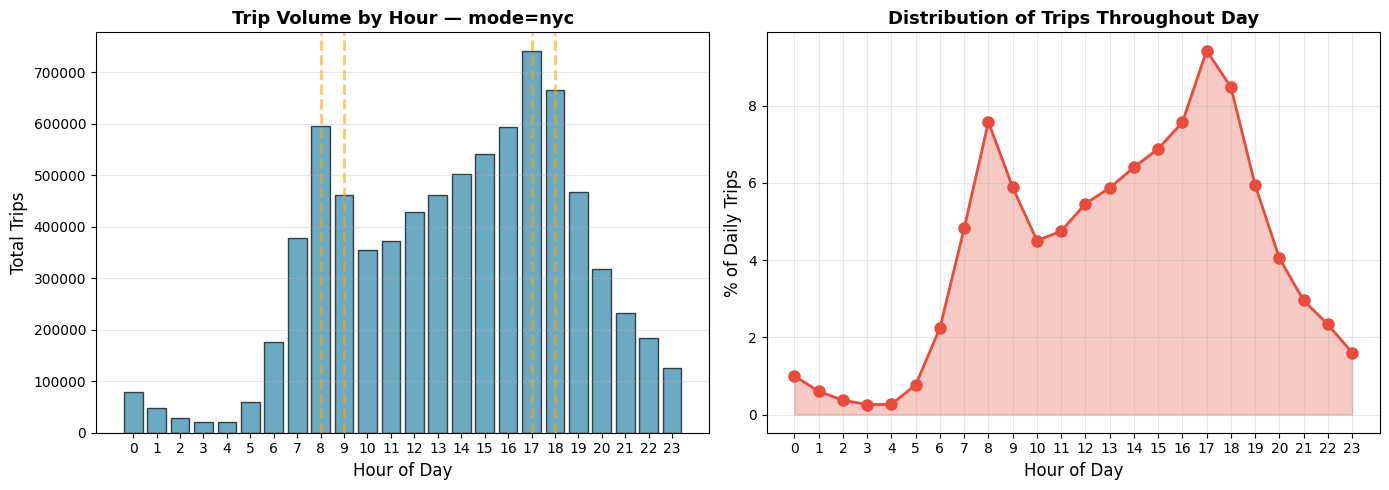


📊 Hour-of-Day Analysis:

Top 5 Busiest Hours:


,hour,trips,pct_of_daily
17,17,740396,9.425136
18,18,666072,8.479002
8,8,595138,7.576022
16,16,594324,7.565660
15,15,540421,6.879483


In [5]:
# --- TEMPORAL PATTERNS: HOUR OF DAY ---
if df_hour is not None:
    print("\n" + "="*70)
    print("TEMPORAL PATTERNS: HOUR OF DAY")
    print("="*70)
    
    # Hour data is already aggregated system-wide
    hour_summary = df_hour.groupby('hour')['trips'].sum().reset_index()
    hour_summary = hour_summary.sort_values('hour')
    
    # Calculate percentage of daily trips
    total_trips = hour_summary['trips'].sum()
    hour_summary['pct_of_daily'] = (hour_summary['trips'] / total_trips) * 100
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Trip volume by hour
    ax1.bar(hour_summary['hour'], hour_summary['trips'], 
           color='#2E86AB', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Hour of Day', fontsize=12)
    ax1.set_ylabel('Total Trips', fontsize=12)
    ax1.set_title(f'Trip Volume by Hour — mode={mode}', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(0, 24))
    ax1.grid(alpha=0.3, axis='y')
    
    # Mark rush hours
    rush_hours = [8, 9, 17, 18]
    for rh in rush_hours:
        ax1.axvline(rh, color='orange', linestyle='--', alpha=0.6, linewidth=2)
    
    # 2. Percentage distribution
    ax2.plot(hour_summary['hour'], hour_summary['pct_of_daily'], 
            marker='o', linewidth=2, markersize=8, color='#E74C3C')
    ax2.fill_between(hour_summary['hour'], hour_summary['pct_of_daily'], 
                     alpha=0.3, color='#E74C3C')
    ax2.set_xlabel('Hour of Day', fontsize=12)
    ax2.set_ylabel('% of Daily Trips', fontsize=12)
    ax2.set_title('Distribution of Trips Throughout Day', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(0, 24))
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    savefig("09_trips_by_hour.png")
    plt.show()
    
    print("\n📊 Hour-of-Day Analysis:")
    top_hours = hour_summary.nlargest(5, 'trips')[['hour', 'trips', 'pct_of_daily']]
    print("\nTop 5 Busiest Hours:")
    display(top_hours)


TEMPORAL PATTERNS: DAY OF WEEK


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_3_modenyc/figures/10_trips_by_day_of_week.png


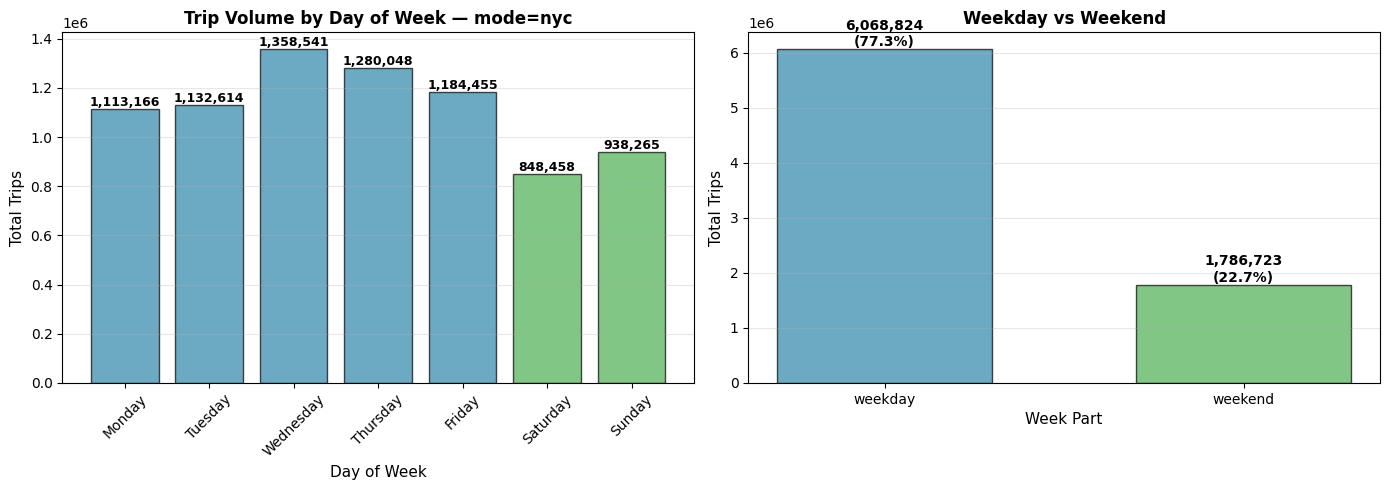


📊 Day-of-Week Analysis:


,dow_name,trips,pct_of_weekly
0,Monday,1113166,14.170445
1,Tuesday,1132614,14.418016
2,Wednesday,1358541,17.294034
3,Thursday,1280048,16.294830
4,Friday,1184455,15.077944
5,Saturday,848458,10.800750
6,Sunday,938265,11.943980


In [6]:
# --- TEMPORAL PATTERNS: DAY OF WEEK (robust) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if df_dow is None:
    print("df_dow is None; skipping DOW section.")
else:
    print("\n" + "="*70)
    print("TEMPORAL PATTERNS: DAY OF WEEK")
    print("="*70)

    d = df_dow.copy()

    if "dow" not in d.columns or "trips" not in d.columns:
        raise KeyError(f"df_dow missing required columns. Have: {list(d.columns)}")

    d["dow"] = pd.to_numeric(d["dow"], errors="coerce")
    d["trips"] = pd.to_numeric(d["trips"], errors="coerce").fillna(0).astype(int)
    d = d.dropna(subset=["dow"]).copy()
    d["dow"] = d["dow"].astype(int)

    if "dow_name" not in d.columns:
        dow_map = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
        d["dow_name"] = d["dow"].map(dow_map).fillna(d["dow"].astype(str))

    if "week_part" not in d.columns:
        d["week_part"] = np.where(d["dow"] >= 5, "weekend", "weekday")

    dow_summary = (
        d.groupby(["dow", "dow_name"], as_index=False)["trips"]
         .sum()
         .sort_values("dow")
    )

    total_trips = dow_summary["trips"].sum()
    dow_summary["pct_of_weekly"] = (dow_summary["trips"] / total_trips) * 100 if total_trips > 0 else 0.0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    colors = ["#4CAF50" if x in ("Saturday","Sunday") else "#2E86AB" for x in dow_summary["dow_name"]]
    ax1.bar(dow_summary["dow_name"], dow_summary["trips"], color=colors, edgecolor="black", alpha=0.7)
    ax1.set_xlabel("Day of Week", fontsize=11)
    ax1.set_ylabel("Total Trips", fontsize=11)
    ax1.set_title(f"Trip Volume by Day of Week — mode={mode}", fontsize=12, fontweight="bold")
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(alpha=0.3, axis="y")

    for i, row in dow_summary.reset_index(drop=True).iterrows():
        ax1.text(i, row["trips"], f"{row['trips']:,.0f}",
                 ha="center", va="bottom", fontweight="bold", fontsize=9)

    wp = d.groupby("week_part", as_index=False)["trips"].sum()
    wp["pct"] = (wp["trips"] / wp["trips"].sum()) * 100 if wp["trips"].sum() > 0 else 0.0
    colors_wp = ["#2E86AB" if x == "weekday" else "#4CAF50" for x in wp["week_part"]]
    ax2.bar(wp["week_part"], wp["trips"], color=colors_wp, edgecolor="black", width=0.6, alpha=0.7)
    ax2.set_xlabel("Week Part", fontsize=11)
    ax2.set_ylabel("Total Trips", fontsize=11)
    ax2.set_title("Weekday vs Weekend", fontsize=12, fontweight="bold")
    ax2.grid(alpha=0.3, axis="y")

    for i, row in wp.reset_index(drop=True).iterrows():
        ax2.text(i, row["trips"], f"{row['trips']:,.0f}\n({row['pct']:.1f}%)",
                 ha="center", va="bottom", fontweight="bold", fontsize=10)

    plt.tight_layout()
    savefig("10_trips_by_day_of_week.png")
    plt.show()

    print("\n📊 Day-of-Week Analysis:")
    display(dow_summary[["dow_name", "trips", "pct_of_weekly"]])


### 8.4 Executive Risk Summary for AXA

In [7]:
# --- EXECUTIVE RISK SUMMARY ---
if df_score is not None:
    print("\n" + "="*70)
    print("EXECUTIVE RISK SUMMARY FOR AXA")
    print("="*70)
    
    # Create summary metrics
    summary_data = []
    
    # Overall metrics
    total_stations = len(df_score)
    credible_count = len(df_score[df_score['credibility_flag'] == 'credible'])
    
    summary_data.append({
        'Metric': 'Total Stations',
        'Value': f"{total_stations:,}",
        'Notes': f"{mode.upper()} mode"
    })
    
    summary_data.append({
        'Metric': 'Credible Stations (≥5K trips)',
        'Value': f"{credible_count:,} ({credible_count/total_stations*100:.1f}%)",
        'Notes': 'Suitable for risk-based pricing'
    })
    
    # Risk tiers
    if 'risk_tier' in credible_stations.columns:
        high_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'High Risk'])
        medium_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'Medium Risk'])
        low_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'Low Risk'])
        
        summary_data.append({
            'Metric': 'High Risk Stations',
            'Value': f"{high_risk_count:,} ({high_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Premium pricing tier'
        })
        
        summary_data.append({
            'Metric': 'Medium Risk Stations',
            'Value': f"{medium_risk_count:,} ({medium_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Standard pricing tier'
        })
        
        summary_data.append({
            'Metric': 'Low Risk Stations',
            'Value': f"{low_risk_count:,} ({low_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Discount pricing tier'
        })
    
    # Hotspots
    if 'prevention_hotspot' in df_score.columns:
        prevention_count = df_score['prevention_hotspot'].sum()
        summary_data.append({
            'Metric': 'Prevention Hotspots',
            'Value': f"{int(prevention_count):,}",
            'Notes': 'High exposure + High risk → Safety campaigns'
        })
    
    if 'product_hotspot' in df_score.columns:
        product_count = df_score['product_hotspot'].sum()
        summary_data.append({
            'Metric': 'Product Hotspots',
            'Value': f"{int(product_count):,}",
            'Notes': 'High exposure → Insurance sales opportunity'
        })
    
    if 'acquisition_hotspot' in df_score.columns:
        acquisition_count = df_score['acquisition_hotspot'].sum()
        summary_data.append({
            'Metric': 'Acquisition Hotspots',
            'Value': f"{int(acquisition_count):,}",
            'Notes': 'High exposure + Low risk → Easy wins'
        })
    
    # Display summary table
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)
    
    # Save to CSV
    summary_csv = RUN_DIR / "risk_executive_summary.csv"
    df_summary.to_csv(summary_csv, index=False)
    print(f"\n✅ Saved executive summary to: {summary_csv}")


EXECUTIVE RISK SUMMARY FOR AXA


,Metric,Value,Notes
0,Total Stations,"2,535",NYC mode
1,Credible Stations (≥5K trips),"1,019 (40.2%)",Suitable for risk-based pricing
2,Prevention Hotspots,40,High exposure + High risk → Safety campaigns
3,Product Hotspots,508,High exposure → Insurance sales opportunity
4,Acquisition Hotspots,290,High exposure + Low risk → Easy wins



✅ Saved executive summary to: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2017_2023_m1_2_3_modenyc/risk_executive_summary.csv
